<a href="https://colab.research.google.com/github/raknampuna/coronavirus-data/blob/master/mankar_anup_ec_csci82-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this extra credit assignement, I wanted to make a model which I could classify whether a particular hashtag generally is positive or negative.  I did this with sentiment analysis on tweets related to Marvel Endgame.  

In [97]:
!pip install textblob

In [98]:
import os
from google.colab import files, drive
import pandas as pd
import numpy as np

import nltk # pip install nltk
from nltk.corpus import stopwords # nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize
from textblob import TextBlob 
from nltk.util import ngrams 

from gensim.models.doc2vec import TaggedDocument, Doc2Vec

import matplotlib.pyplot as plt


In [99]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [102]:
os.getcwd()

#clean data
endgame_tweets = pd.read_csv("/content/gdrive/MyDrive/endgame_tweets.csv",encoding='cp1252')
endgame_tweets["clean_text"] = endgame_tweets.text.replace({'\n': ' ','\r':' ','https://t.co/':'', \
                                                            'Endgame':'',"endgame":'',"Black Widow":''\
                                                            ,"Black":'',"black":'',"Scarlett":''\
                                                            }, regex=True) #cleaning up characters



#doc2vec function
def doc2vec_func(df_in, v = 3):
  df = df_in 
  v_dim = v
  j = df.shape[0]
  corpus = df.clean_text 

  tagged_corpus = [
      TaggedDocument(words, ['d{}'.format(idx)]) 
      for idx, words in enumerate(corpus)
    ]

  model = Doc2Vec(tagged_corpus, size=v_dim, min_count=0)
  
  i = 0
  vecs = []
  while i < j:
    vecs.append(model.docvecs[i])
    i = i + 1
  vecs = pd.DataFrame(vecs)

  df = pd.concat([df_in,vecs],axis = 1)
  return df


#create features
def create_feat(data):

  #analyze sentiment
  tweet_sent = []
  for tweet in data.clean_text:
    tb = TextBlob(tweet)
    tweet_sent.append(tb.sentiment.polarity)
  data = pd.concat([data,pd.DataFrame(tweet_sent)],axis=1)

  data.rename(columns={0:'polarity'}, inplace=True)
  data = data.loc[:,["favorited","favoriteCount","retweetCount","isRetweet","clean_text","polarity"]]
  
  return data
  
endgame_tweets =  create_feat(endgame_tweets)

num_vec = 2
endgame_tweets = doc2vec_func(endgame_tweets,num_vec)

endgame_tweets.head(3)

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


,favorited,favoriteCount,retweetCount,isRetweet,clean_text,polarity,0,1
0,False,0,637,True,RT @mrvelstan: literally nobody: me: #Aven...,0.000000,-0.310600,-0.198281
1,False,0,302,True,"RT @agntecarter: i’m emotional, sorry!! 201...",-0.390625,-0.173240,-0.316277
2,False,0,0,False,saving these bingo cards for tomorrow © #A...,0.000000,-0.048898,-0.302455


Above, I pulled in my tweets from a kaggle dataset I found here:
https://www.kaggle.com/kavita5/twitter-dataset-avengersendgame

I removed some imporant stopwords. The ones I cared about the most where ones that would likely have an unintentional impact on polarity - for example "black" in this context would like come up a lot in the context of Black Panther, where as normally it could have some kind of negative cannotation. 

Below, I also did a simple rounding with my polarity values to have a simpler categorical classification of negative, neutral and positive tweets.  

There is definitely a lot of room for improvement on this cleaning step. Also our polarity doesn't capture things like sarcasm / humor - there are a number of tweets where "macho" guys are joking about how they're "not crying" - these were lower or negative sentiment.  I think it's hard for the analysis to understand that cryibg is good in movies. 


I used these rounded values and my doc2vec of 2 dimensions to visualize to see if there's anything interesting going on.  

In [119]:
sum(endgame_tweets["pol_round"] ==-1)


27

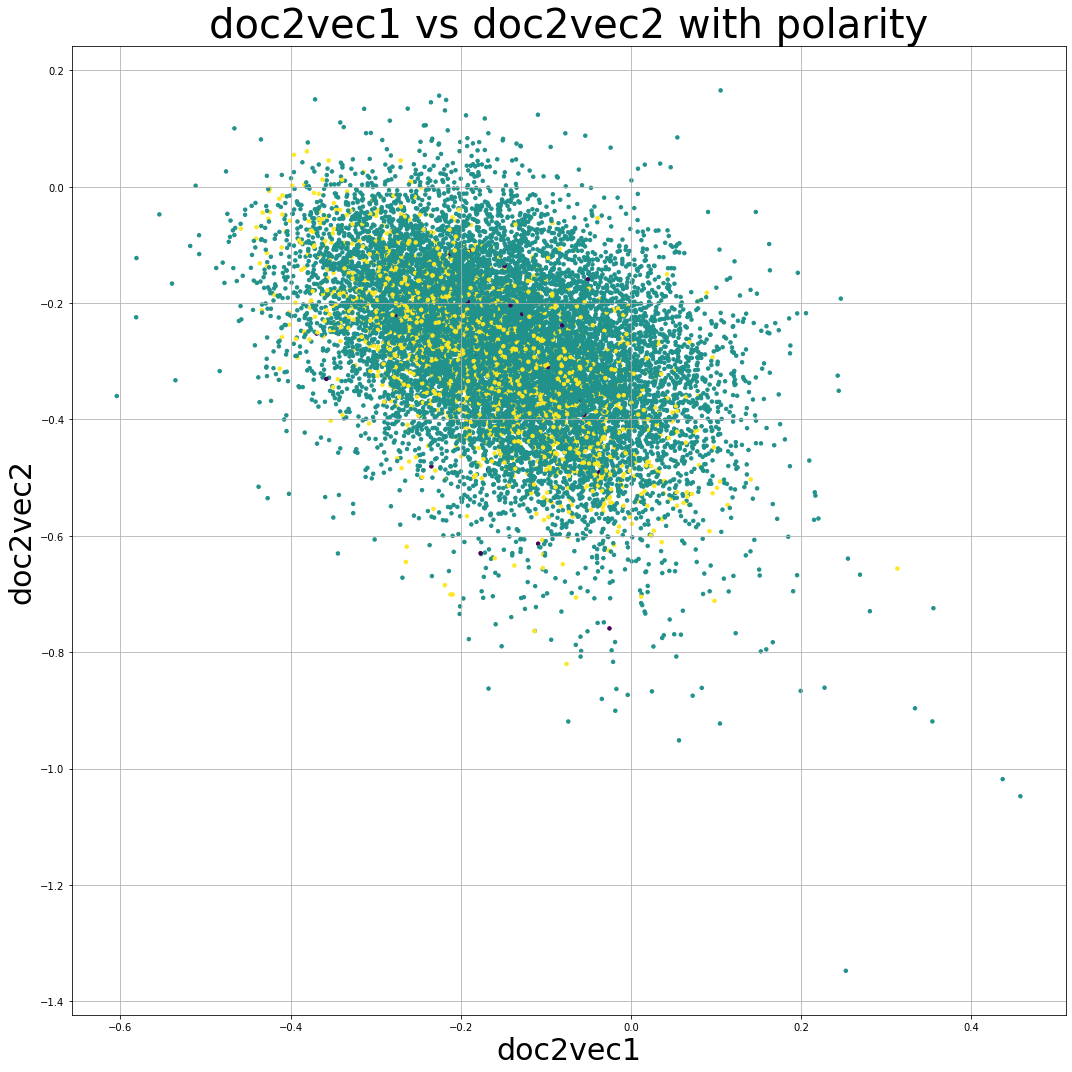

In [112]:
endgame_tweets["pol_round"] = np.round(endgame_tweets.polarity)
labs = endgame_tweets.pol_round
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(endgame_tweets.loc[:, 0], endgame_tweets.loc[:, 1], c=labs, s=12, cmap='viridis')

c1 = "doc2vec1"
c2 = "doc2vec2"

ax.set_xlabel(c1, fontsize=30)
ax.set_ylabel(c2, fontsize=30)
ax.set_title(c1+" vs "+c2 +" with polarity", fontsize=40)

ax.grid(True)
fig.tight_layout()

Nothing very interesting here.  The yellow are positive tweets and the dark blue are the negative  We do see some outliers but analyzing those is not  my goal here.  It's also just very dense.  Since I don't really care about my neutral tweets, and since there's a lot of them, I 'm going to drop them from the dataset

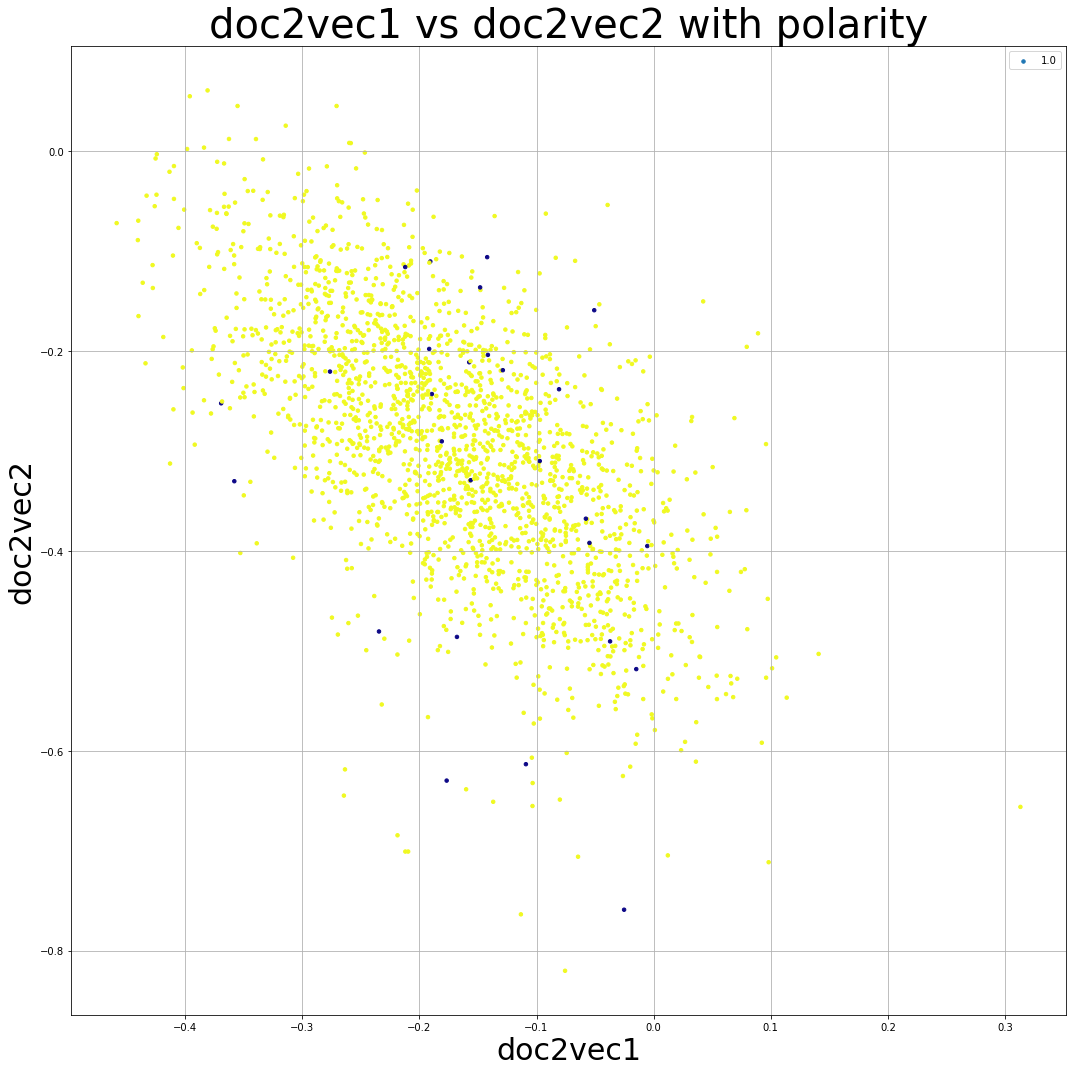

In [113]:
eg_polar = endgame_tweets[endgame_tweets.pol_round != 0]

labs = eg_polar.pol_round
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(eg_polar.loc[:, 0], eg_polar.loc[:, 1], c=labs, s=12, cmap='plasma')

c1 = "doc2vec1"
c2 = "doc2vec2"

ax.set_xlabel(c1, fontsize=30)
ax.set_ylabel(c2, fontsize=30)
ax.set_title(c1+" vs "+c2 +" with polarity", fontsize=40)

ax.legend(labs)
ax.grid(True)
fig.tight_layout()

Again, nothing too interesting with the distribution, though it does seem the negative tweets (darker dots) are distributed a bit more randomly.  The main goal is not to predict tweets or find clusters, so I'll move on.  

In [121]:
print(len(endgame_tweets.polarity[endgame_tweets.polarity > 0]), "number of positive tweets about Endgame")
print(len(endgame_tweets.polarity[endgame_tweets.polarity == 0]), "number of neutral tweets about Endgame")
print(len(endgame_tweets.polarity[endgame_tweets.polarity < 0]), "number of negative tweets about Endgame")
endgame_tweets["pol_round"] = np.round(endgame_tweets.polarity)
print(len(endgame_tweets.polarity[endgame_tweets.pol_round == 1]), "number of VERY positive tweets about Endgame")
print(len(endgame_tweets.polarity[endgame_tweets.pol_round == -1]), "number of VERY negative tweets about Endgame")

5478 number of positive tweets about Endgame
8847 number of neutral tweets about Endgame
675 number of negative tweets about Endgame
1991 number of VERY positive tweets about Endgame
27 number of VERY negative tweets about Endgame


This is probably my most import cell - simple counts of what are positive, negative, and neutral tweets.  It reflects what we saw earlier in the visualizations.  There are a lot more positive tweets than negative tweets.  

My ultimate goal here is to create a simple metric which I can use in the future for sentiment analysis classification.  To that end, I'm simply going to clasify create a metric based on the positive tweets over the negative tweets

In [129]:
np.log(len(endgame_tweets.polarity[endgame_tweets.pol_round == 1]) / len(endgame_tweets.polarity[endgame_tweets.pol_round == -1]))

4.300555438059868